In [217]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [218]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [219]:
IN_DIR = ""
OUT_DIR = ""

In [220]:
ptv_result = [0] * 40

In [221]:
columns = ["x", "y", "dx", "dy", "p0", "p1"]

In [222]:
for i in tqdm(range(5100, 5500, 10)):
    try:
        r = pd.read_csv("ptv/" + f"pp_{i}.csv", delimiter=',')
        r = pd.DataFrame(data=r.values, columns=columns)
    except StopIteration:
        r = None
    except OSError:
        r = None

    if r is None:
        pass
    else:
        for row in r.index:
            if (r.loc[row] == 0).all():
                r.drop(row, axis=0, inplace=True)
        ptv_result[(i-5100)//10] = r

100%|██████████| 40/40 [00:00<00:00, 144.32it/s]


In [223]:
result = np.zeros([40, 1000, 6])  # x, y, dx, dy, p1, flag
result[:, :, :-1] = np.nan
p, p_max = 0, 0

In [224]:
for t in tqdm(range(40)):
    if t == 0:
        tmp = ptv_result[t].sort_values(by='p0', ascending=True)
        p_max = tmp.values.shape[0]

        result[t, :p_max] = np.hstack([np.hstack([tmp.values[:, :4], tmp.values[:, 5:]]), np.ones([p_max, 1])])

    else:
        tmp = ptv_result[t].sort_values(by='p0', ascending=True)
        p = p_max

        for j in range(tmp.values.shape[0]):
            is_exist = False

            for i in range(p_max):
                if is_exist:
                    continue

                if tmp.values[j, 4] == result[t - 1, i, 4]:
                    result[t, i, :4] = tmp.values[j, :4]
                    result[t, i, 4] = tmp.values[j, 5]
                    result[t, i, 5] = 1
                    is_exist = True

                elif result[t - 1, i, 4] == -1 and \
                    np.sqrt(
                        (result[t - 1, i, 0] + result[t - 1, i, 2] - tmp.values[j, 0]) ** 2 + \
                        (result[t - 1, i, 1] + result[t - 1, i, 3] - tmp.values[j, 1]) ** 2
                    ) < 10:
                    result[t, i, :4] = tmp.values[j, :4]
                    result[t, i, 4] = tmp.values[j, 5]
                    result[t, i, 5] = 1
                    is_exist = True

            if not is_exist:
                result[t, p, :4] = tmp.values[j, :4]
                result[t, p, 4] = tmp.values[j, 5]
                result[t, p, 5] = 1
                p += 1

        for i in range(p_max):
            if result[t, i, 5] == 0:
                result[t, i, 0] = result[t - 1, i, 0] + result[t - 1, i, 2]
                result[t, i, 1] = result[t - 1, i, 1] + result[t - 1, i, 3]
                result[t, i, 2:4] = result[t - 1, i, 2:4]
                result[t, i, 4] = -1  # predict

        p_max = p

100%|██████████| 40/40 [00:01<00:00, 24.93it/s]


In [225]:
result = result[:, :p_max, :]

In [226]:
for t in range(40):
    for j in range(p_max):
        if result[t, j, 5] == 0:
            result[t, j, :5] = np.nan

/Users/loblium/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/loblium/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


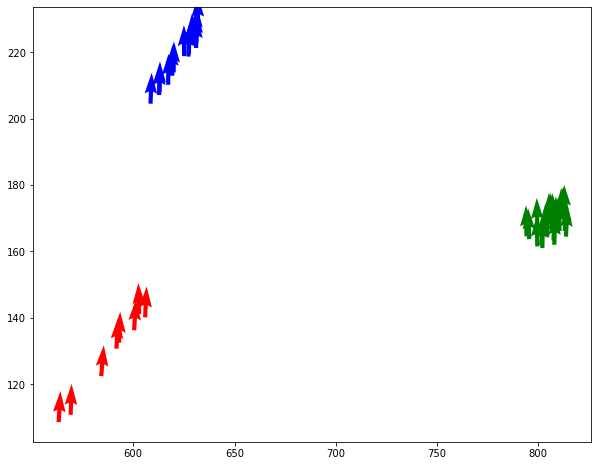

In [230]:
fig, ax = plt.subplots(figsize=(10, 8))

k = 10

for t in range(40):
    # ax.scatter(result[t, k, 0], result[t, k, 1])
    ax.quiver(result[t, k, 0], result[t, k, 1], result[t, k, 3], result[t, k, 4], color='r')
    ax.quiver(result[t, k+3, 0], result[t, k+3, 1], result[t, k+3, 3], result[t, k+3, 4], color='g')
    ax.quiver(result[t, k+5, 0], result[t, k+5, 1], result[t, k+5, 3], result[t, k+5, 4], color='b')

plt.show()